<a href="https://colab.research.google.com/github/xuanyuw/NOVA1_variation_LFP/blob/main/analyze_LFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from scipy.io import loadmat
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [4]:
nova_fns = sorted([mat for mat in glob.glob('/content/drive/My Drive/NOVA1_LFP/NOVA1/44-136_LFP/*.mat')])
ctc_fns = ['/content/drive/My Drive/NOVA1_LFP/CTC/'+ fn for fn in ['LFP_Sp_010617.mat', 'LFP_Sp_011317.mat', 'LFP_Sp_012717.mat', 'LFP_Sp_022417.mat']]
nova_files = [h5py.File(fn, 'r') for fn in nova_fns]
ctc_files = [h5py.File(fn, 'r') for fn in ctc_fns]

In [5]:
nova_fns

['/content/drive/My Drive/NOVA1_LFP/NOVA1/44-136_LFP/LFP_Sp_012119.mat',
 '/content/drive/My Drive/NOVA1_LFP/NOVA1/44-136_LFP/LFP_Sp_013019.mat',
 '/content/drive/My Drive/NOVA1_LFP/NOVA1/44-136_LFP/LFP_Sp_021219.mat',
 '/content/drive/My Drive/NOVA1_LFP/NOVA1/44-136_LFP/LFP_Sp_031119.mat']

In [6]:
ctc_fns

['/content/drive/My Drive/NOVA1_LFP/CTC/LFP_Sp_010617.mat',
 '/content/drive/My Drive/NOVA1_LFP/CTC/LFP_Sp_011317.mat',
 '/content/drive/My Drive/NOVA1_LFP/CTC/LFP_Sp_012717.mat',
 '/content/drive/My Drive/NOVA1_LFP/CTC/LFP_Sp_022417.mat']

In [7]:
fs_orig = 12500
num_channels = 64
num_wells = 12
#fn = '/content/drive/My Drive/NOVA1_LFP/NOVA1/44-136_LFP/LFP_Sp_013019.mat'
# file = h5py.File(fn, 'r')
# lfp = np.array(file['LFP']).flatten()
# fs_ds = np.array(file['fs_ds'])[0]
#spike_avg = np.array(file['spike_avg'])
#spikes = np.array(file['spikes'])
#spike_cnt = np.array(file['spike_cnt'])


## Spiking rate (Done)

In [ ]:
def calc_spk_rate(file):
  total_spks = np.array(file['spike_cnt']).max()
  total_time = max(file['t_s'][0])
  return total_spks/total_time

sr_nova = [calc_spk_rate(file) for file in nova_files]
sr_ctc = [calc_spk_rate(file) for file in ctc_files]

In [ ]:
sr_nova

[8.879671979937806, 11.374740128301587, 13.046837706595133, 16.493082102197054]

Text(0.5, 1.0, 'Spiking rate of nova1 variant and wild type')

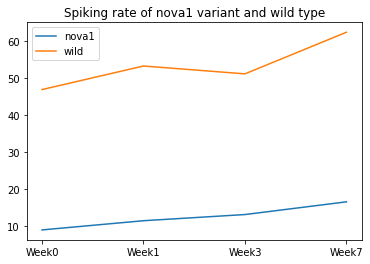

In [ ]:
plt.plot(sr_nova, label='nova1')
plt.plot(sr_ctc, label='wild')
plt.xticks(labels=['Week0','Week1','Week3','Week7'], ticks=range(4))
plt.legend(loc='best')
plt.title('Spiking rate of nova1 variant and wild type')

## Inter-spike interval distribution (Done)

In [ ]:

def calculate_isi(file, fs_orig=fs_orig, num_channels=num_channels, num_wells=num_wells):
  all_isi = []
  spikes = np.array(file['spikes'])
  for i in range(num_wells):
    isi = []
    for j in range(num_channels):
      spks = np.array(file[spikes[j, i]]).flatten()
      isi.append(np.diff(spks).flatten())
    if len(isi)>0:
      isi = np.hstack(isi)
      all_isi.append(isi)
  
  return np.hstack(all_isi)

nova_isi = [calculate_isi(file) for file in nova_files]
ctc_isi = [calculate_isi(file) for file in ctc_files]

Text(0, 0.5, 'Count')

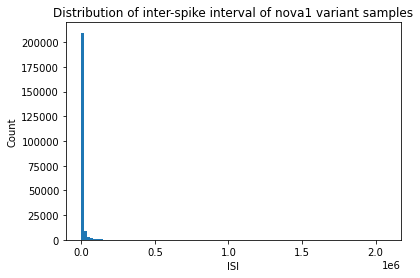

In [ ]:
plt.hist(np.hstack(nova_isi),bins=100)
plt.title('Distribution of inter-spike interval of nova1 variant samples')
plt.xlabel('ISI')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

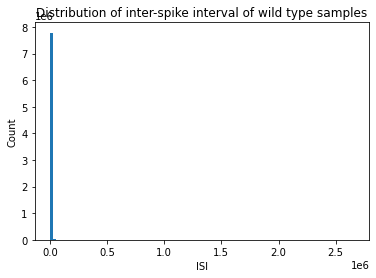

In [ ]:
plt.hist(np.hstack(ctc_isi),bins=100)
plt.title('Distribution of inter-spike interval of wild type samples')
plt.xlabel('ISI')
plt.ylabel('Count')

In [ ]:
nova_isi_mean = np.mean(np.hstack(nova_isi))
ctc_isi_mean = np.mean(np.hstack(ctc_isi))
nova_isi_std = np.std(np.hstack(nova_isi))
ctc_isi_std = np.std(np.hstack(ctc_isi))

In [ ]:
print('nova1 mean = %f, std = %f' %(nova_isi_mean, nova_isi_std))
print('wild mean = %f, std = %f' %(ctc_isi_mean, ctc_isi_std))

nova1 mean = 8724.939584, std = 43344.913255
wild mean = 743.545699, std = 9962.695587


## CV (quantify network complexity)(Done)

The inter-event interval coefficient of variation (IEI CV) was calculated as the standard deviation of the inter-event interval divided by its mean, where IEI is the time
between consecutive network events within the same MEA well.

In [46]:
def extract_events(well_id, channel_id, file, fs_orig = fs_orig, event_start=-0.5, event_end=2.5):
  events_t0 = []
  fs = np.array(file['fs_ds'])[0][0]
  event_len = int(fs*(abs(event_start)+abs(event_end)))
  spikes = np.array(file['spikes'])
  spks = np.array(file[spikes[channel_id, well_id]]).flatten()
  spks = (spks*fs/fs_orig).astype('int') #convert index according to down-sampled sampling rate
  prev = spks[:-2]
  post = spks[2:] 
  diff = post - prev
  events_freq = prev[diff<event_len]
  freq_prev = events_freq[:-1]
  freq_post = events_freq[1:]
  dist = freq_post - freq_prev
  t0_index = dist>(event_end+1)*fs
  if sum(t0_index) > 0:
    events_t0 = np.insert(freq_post[t0_index], 0, freq_prev[0])
  return events_t0

def calculate_iei_cv(file, fs_orig=fs_orig, num_channels=num_channels, num_wells=num_wells):
  all_cv = []
  for i in range(num_wells):
    iei = []
    #print(i)
    for j in range(num_channels):
      events_t0 = extract_events(i, j, file)
      iei.append(np.diff(events_t0).flatten())
    if len(iei)>0:
      iei = np.hstack(iei)
      iei = iei/fs_orig
      iei_mean = np.nanmean(iei)
      iei_std = np.nanstd(iei)
      all_cv.append(iei_std/iei_mean)
    else:
      all_cv.append(np.nan)
  return all_cv

nova_cv = [calculate_iei_cv(file) for file in nova_files]
ctc_cv = [calculate_iei_cv(file) for file in ctc_files]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [47]:
nova_mean_cv = [np.nanmean(cv) for cv in nova_cv]
ctc_mean_cv = [np.nanmean(cv) for cv in ctc_cv]
print(nova_mean_cv)
print(ctc_mean_cv)
print(np.array(ctc_mean_cv) - np.array(nova_mean_cv))

[0.8777461350692072, 0.6367350196092066, 0.7323224381637359, 0.664680766521586]
[0.49906268754821803, 0.5952324721664751, 0.6059996824771107, 0.5486879825222946]
[-0.37868345 -0.04150255 -0.12632276 -0.11599278]


(0.4, 1.0)

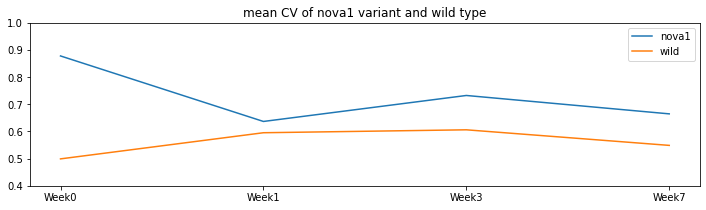

In [51]:
plt.plot(nova_mean_cv, label='nova1')
plt.plot(ctc_mean_cv, label='wild')
#plt.plot(np.array(ctc_mean_cv) - np.array(nova_mean_cv), label='difference')
plt.xticks(labels=['Week0','Week1','Week3','Week7'], ticks=range(4))
plt.legend(loc='best')
plt.title('mean CV of nova1 variant and wild type')
plt.ylim([0.4, 1])

In [50]:
import statistics
nova_median_cv = [statistics.median(np.array(cv)[~np.isnan(cv)]) for cv in nova_cv]
ctc_median_cv = [statistics.median(np.array(cv)[~np.isnan(cv)]) for cv in ctc_cv]
print(nova_median_cv)
print(ctc_median_cv)
print(np.array(ctc_median_cv) - np.array(nova_median_cv))

[0.8966441096229855, 0.6026151548900075, 0.7648832912122434, 0.7169757224429186]
[0.5175450553596397, 0.6398449531193454, 0.5798928957222348, 0.5291061470711726]
[-0.37909905  0.0372298  -0.1849904  -0.18786958]


(0.4, 1.0)

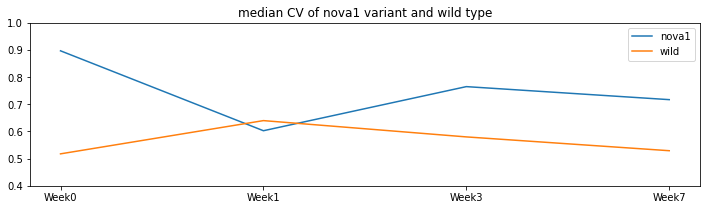

In [52]:
plt.plot(nova_median_cv, label='nova1')
plt.plot(ctc_median_cv, label='wild')
#plt.plot(np.array(ctc_median_cv) - np.array(nova_median_cv), label='difference')
plt.xticks(labels=['Week0','Week1','Week3','Week7'], ticks=range(4))
plt.legend(loc='best')
plt.title('median CV of nova1 variant and wild type')
plt.ylim([0.4, 1])

## LFP Trace ?

In [47]:
file = nova_files[0]
event_start = -0.5
event_end = 2.5
fs = np.array(file['fs_ds'])[0]
# i=0
# j=1
well_avg_events = []
event_len = int(fs*(abs(event_start)+abs(event_end)))
for i in range(num_wells):
  print(i)
  num_events = 0
  well_events = np.zeros(event_len)
  for j in range(num_channels):
    events_t0 = extract_events(i, j, file)
    lfp = np.array(file[np.array(file['LFP']).flatten()[i]])[j, :]
    if len(events_t0)!=0:
      #print(i, j)
      for t0 in events_t0:
        event = lfp[int(t0+event_start*fs):int(t0+event_end*fs)]
        if len(event)==event_len:
          well_events = np.add(well_events, event)
          num_events += 1
  well_avg_events.append(well_events/num_events)

0


KeyboardInterrupt: ignored

In [ ]:
events_t0

[]

## LFP Amplitude?

## Spike field coherence (Done)

In [8]:
def extract_events(well_id, channel_id, file, fs_orig = fs_orig, event_start=-0.5, event_end=2.5):
  events_t0 = []
  fs = np.array(file['fs_ds'])[0][0]
  event_len = int(fs*(abs(event_start)+abs(event_end)))
  spikes = np.array(file['spikes'])
  spks = np.array(file[spikes[channel_id, well_id]]).flatten()
  spks = (spks*fs/fs_orig).astype('int') #convert index according to down-sampled sampling rate
  prev = spks[:-2]
  post = spks[2:] 
  diff = post - prev
  events_freq = prev[diff<event_len]
  freq_prev = events_freq[:-1]
  freq_post = events_freq[1:]
  dist = freq_post - freq_prev
  t0_index = dist>(event_end+1)*fs
  if sum(t0_index) > 0:
    events_t0 = np.insert(freq_post[t0_index], 0, freq_prev[0])
  return events_t0

In [9]:
import scipy.io as sio
from pylab import *


def extract_lfp_seg(lfp, events_t0, fs, event_len, event_start, event_end):
  all_start = np.array(events_t0).astype('int') + int(event_start*fs)
  all_end = np.array(events_t0).astype('int') + int(event_end*fs)
  lfp_events = np.vstack([lfp[all_start[i]:all_end[i]] for i in range(len(events_t0)) if len(lfp[all_start[i]:all_end[i]])==event_len])
  return lfp_events

def extract_spks_seg(spks, fs, num_events, event_len, event_start, event_end):
  spks_events = np.zeros((num_events, event_len))
  for i in range(num_events):
    shifted_spks = spks - i + int(event_start*fs)
    shifted_spks = shifted_spks[np.logical_and(shifted_spks>=0, shifted_spks<=int(event_end*fs))]
    spks_events[i, shifted_spks] = 1
  return spks_events
  
def calculate_sfc(well_id, channel_id, file, fs_orig = fs_orig, event_start=-0.5, event_end=2.5):
  # https://mark-kramer.github.io/Case-Studies-Python/11.html
  fs = np.array(file['fs_ds'])[0][0]
  events_t0 = extract_events(well_id, channel_id, file)
  N = int(fs*(abs(event_start)+abs(event_end))) 
  if len(events_t0)>0:
    event_len = int(fs*(abs(event_start)+abs(event_end)))
    lfp = np.array(file[np.array(file['LFP']).flatten()[well_id]])[channel_id, :]
    lfp_events = extract_lfp_seg(lfp, events_t0, fs, event_len, event_start, event_end)
    num_events = lfp_events.shape[0]

    spikes = np.array(file['spikes'])
    spks = np.array(file[spikes[channel_id, well_id]]).flatten()
    spks = (spks*fs/fs_orig).astype('int')
    spks_events = extract_spks_seg(spks, fs, num_events, event_len, event_start, event_end)

    t = np.array(file['t_ds'])[0]                       
    K = num_events                                                                  
    dt = t[1]-t[0]                                     
    SYY = zeros(int(N/2+1))                      # Variable to store field spectrum.
    SNN = zeros(int(N/2+1))                      # Variable to store spike spectrum.
    SYN = zeros(int(N/2+1), dtype=complex)              # Variable to store cross spectrum.

    for k in arange(K):                                 # For each trial,
        yf = rfft((lfp_events[k,:]-mean(lfp_events[k,:])) *hanning(N))    # Hanning taper the field,
        nf = rfft((spks_events[k,:]-mean(spks_events[k,:])))                # ... but do not taper the spikes.
        SYY = SYY + (real(yf*conj(yf)))/K           # Field spectrum
        SNN = SNN + (real(nf*conj(nf)))/K           # Spike spectrum
        SYN = SYN + (yf*conj(nf))/K        # Cross spectrum
    cohr = real(SYN*conj(SYN)) / SYY / SNN              # Spike-field coherence
    return cohr
  return zeros(int(N/2+1))

def mean_well_sfc(file):
  all_sfc = []
  for well_id in range(num_wells):
    well_sfc = []
    for channel_id in range(num_channels):
      cohr = calculate_lfp(well_id, channel_id, file)
      well_sfc.append(cohr)
    all_sfc.append(np.nanmean(well_sfc))
  return all_sfc

In [10]:
from tqdm import tqdm
rerun_sfc = 0
if rerun_sfc:
  nova_sfc = []
  print('Calculating sfc of NOVA1 variant samples...')
  for file in tqdm(nova_files):
    nova_sfc.append(mean_well_sfc(file))

  ctc_sfc = []
  print('Calculating sfc of wild type samples...')
  for file in tqdm(ctc_files):
    ctc_sfc.append(mean_well_sfc(file))
    
  with open('/content/drive/My Drive/NOVA1_LFP/nova_sfc.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % sfc for sfc in nova_sfc)

  with open('/content/drive/My Drive/NOVA1_LFP/ctc_sfc.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % sfc for sfc in ctc_sfc)

  0%|          | 0/4 [00:00<?, ?it/s]

Calculating lfp of NOVA1 variant samples...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
  0%|          | 0/4 [00:00<?, ?it/s]

Calculating lfp of wild type samples...


100%|██████████| 4/4 [30:10<00:00, 452.64s/it]


In [39]:
import re
if not rerun_sfc:
  p = re.compile(r'\d+\.\d+')  # Compile a pattern to capture float values
  nova_sfc = []
  with open('/content/drive/My Drive/NOVA1_LFP/nova_sfc.txt', 'r') as filehandle:
    for line in filehandle.readlines():
      nova_sfc.append([float(i) for i in p.findall(line)])

  ctc_sfc = []
  with open('/content/drive/My Drive/NOVA1_LFP/ctc_sfc.txt', 'r') as filehandle:
    for line in filehandle.readlines():
      ctc_sfc.append([float(i) for i in p.findall(line)])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Distribution of Average Spike Field Coherence of Each Well at Each Week')

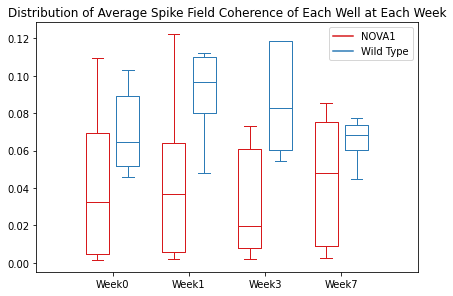

In [40]:
ticks = ['Week0','Week1','Week3','Week7']
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

nova_sfc = [list(np.array(sfc)[np.nonzero(sfc)[0]]) for sfc in nova_sfc]
ctc_sfc = [list(np.array(sfc)[np.nonzero(sfc)[0]]) for sfc in ctc_sfc]

plt.figure()
bpl = plt.boxplot(nova_sfc, positions=np.array(range(len(nova_sfc)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(ctc_sfc, positions=np.array(range(len(ctc_sfc)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='NOVA1')
plt.plot([], c='#2C7BB6', label='Wild Type')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.title('Distribution of Average Spike Field Coherence of Each Well at Each Week')

## PAC 

1. LFP data from all 64 channels of each well was first lowpass/bandpass filtered (eegfilt.m, EEGLAB) for delta (0-4 Hz) and high-frequency, broadband (100-400 Hz) activity

2. Delta phase was extracted by taking the phase
angle of the bandpassed delta signal Hilbert transform (hilbert.m, angle.m), while gamma power was extracted by taking the squared
magnitude of the filtered gamma.

3. Analysis was performed for 100-200 Hz and 200-400 Hz separately

4. instantaneous delta phase was binned into 20 equidistant bins between -pi and pi,
and gamma power was sorted based on the corresponding delta phase at the same sample time and averaged across the same
phase bin

5. This procedure was performed separately for event and non-event indices

6. Modulation Index was
computed as the Kullback-Leibler divergence between the sum-normalized distribution of gamma power across phase bins and a
uniform distribution


In [ ]:
file=ctc_files[0]
lfp = np.array(file['LFP']).flatten()
events = extract_events(10,0,ctc_files[0])
range(len(np.array(file[lfp[0]]))) not in events

ValueError: ignored

In [ ]:
file=ctc_files[0]
spikes = np.array(file['spikes'])
np.array(file[spikes[0, 10]]).flatten()

In [ ]:
# define bandpass filters borrowed from UCSD COGS189WI21 A1 starter code
from scipy.signal import butter, sosfiltfilt, sosfreqz, hilbert
def butter_bandpass(lowcut, highcut, fs, order = 2):
  nyq = 0.5 * fs
  low = lowcut/nyq
  high = highcut/nyq
  sos = butter(order, [low, high], analog=False, btype='band', output='sos')
  return sos
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
  sos = butter_bandpass(lowcut, highcut, fs, order=order)
  y = sosfiltfilt(sos, data)
  return y


In [ ]:
# bandpass all 64 channels to get delta and gamma
t = np.array(file[lfp[0]])
delta = butter_bandpass_filter(t, 0.1, 4, fs_ds)
gamma1 = butter_bandpass_filter(t, 100, 200, fs_ds)
gamma2 = butter_bandpass_filter(t, 200, 400, fs_ds)

In [ ]:
#Get delta phase (From https://www.gaussianwaves.com/2017/04/extract-envelope-instantaneous-phase-frequency-hilbert-transform/)
z= hilbert(delta) #form the analytical signal
inst_amplitude = np.abs(z) #envelope extraction
delta_phase = np.unwrap(np.angle(z))#inst phase
delta_phase.shape

In [ ]:
#Get gamma power
gamma1_power = np.square(gamma1)
gamma2_power = np.square(gamma2)

In [ ]:
gamma1_power.shape

In [ ]:
#Sort gamma power based on delta phase
from scipy.stats import binned_statistic
num_channels = 64
for i in range(num_channels):
  statistics, bin_edges, bin_number = binned_statistic(delta_phase[i, :], gamma1_power[i,:], statistic='mean', bins=20, range=(-np.pi, np.pi))


## Temporal and Spatial Pearson Correlation
Event temporal correlation was calculated as the mean Pearson correlation coefficient of population spiking vector between each pair of network event in the same MEA well across a single recording session. 


Event spatial correlation was calculated as the mean Pearson correlation coefficient between all pairs of 64 LFP channels during each 3 s network event.

The shapes were defined as the LFP sequence of 12 
temporal points before, and 12 temporal points after the peak of the spike, including the 
peak, totalizing 25 temporal points. (Maybe shouldn't be used here...)

In [ ]:
#Separate out events for a certain channel
def extract_events(well_id, channel_id, file, fs, fs_orig = fs_orig, event_start=-0.5, event_end=2.5):
  events = []
  lfp = np.array(file['LFP']).flatten()
  spikes = np.array(file['spikes'])
  spks = np.array(file[spikes[channel_id, well_id]]).flatten()
  lfp_act = np.array(file[lfp[well_id]])[channel_id, :]
  for spk in spks:
    #print(int(spk*fs/fs_orig))
    start = int(event_start * fs + int(spk*fs/fs_orig))
    end = int(event_end * fs + int(spk*fs/fs_orig))
    event = lfp_act[start:end]
    events.append(event)
  return events


In [ ]:
for 

In [ ]:
#temporal correlation
all_temp_corrcoef = []
num_wells = spike_avg.shape[2]
num_channels = spike_avg.shape[1]
for i in range(num_wells):
  #spk_all_channels = [event for j in range(num_channels) for event in extract_events(i, j, file, fs_ds) if len(event)==3000 ]
  spk_all_channels = [np.means(extract_events())]
  spk_all_channels = np.vstack(spk_all_channels)
  temp_corrcoef = np.corrcoef(spk_all_channels, rowvar=True)
  all_temp_corrcoef.append(temp_corrcoef)
final_temp_corrcoef = np.mean(all_temp_corrcoef)

In [ ]:
#spatial correlation
num_wells = spike_avg.shape[2]
num_channels = spike_avg.shape[1]
all_sp_corrcoef = []
for j in range(num_wells):
  event_lfps = []
  for i in range(num_channels):
    events = []
  sp_corrcoef = np.corrcoef(, rowvar=True)
  all_sp_corrcoef.append(sp_corrcoef)
final_sp_corrcoef = np.mean(all_sp_corrcoef)

In [ ]:
final_temp_corrcoef, final_sp_corrcoef

NameError: ignored